In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

In [16]:
match_data = pd.read_csv('data\\gold_dif.csv').sort_values('platformgameid')
match_history = pd.read_csv('data\\match_history.csv').rename({'gameid' : 'platformgameid'}, axis = 1)[['platformgameid', 'winning_side']]
# match_history['winning_side'] = match_history['winning_side'].apply(lambda x: 'blue' if x == 100 else 'red')
match_data = match_data.merge(match_history, how = 'inner', on = 'platformgameid')

In [17]:
def parse_string_to_dict_list(string):
    dict_list = []
    dict_strs = string.split("}, {")
    for dict_str in dict_strs:
        dict_items = dict_str.replace('[', '').replace(']', '').replace('{', '').replace('}', '').split(", ")
        new_dict = {}
        for dict_item in dict_items:
            key, value = dict_item.split("=")
            new_dict[key] = int(value)
        dict_list.append(new_dict)
    return dict_list


In [18]:
match_data['teams'] = match_data['teams'].apply(lambda x: parse_string_to_dict_list(x))

In [19]:
match_data.head(1)['teams'].values[0][1]['totalgold']

21708

In [20]:
mh_df = pd.DataFrame(
    columns=[
        "team_gold",
        "team_gold_lead",
        "team_towers",
        "team_dragons",
        "team_barons",
        "team_kills",
        "team_deaths",
        "team_assists",
    ]
)

for match in match_data.loc[match_data["game_event"] == "lane_state"].itertuples():
    for i in range(2):
        mh_df = mh_df.append(
            {
                "result": "win" if int(str(match.winning_side - 100)[0]) == i else "lose",
                "team_gold": match.teams[i]["totalgold"],
                "team_gold_lead": match.teams[i]["totalgold"]
                - match.teams[1 - i]["totalgold"],
                "team_towers": match.teams[i]["towerkills"],
                "team_dragons": match.teams[i]["dragonkills"],
                "team_barons": match.teams[i]["baronkills"],
                "team_kills": match.teams[i]["championskills"],
                "team_deaths": match.teams[i]["deaths"],
                "team_assists": match.teams[i]["assists"],
            },
            ignore_index=True,
        ).reset_index(drop=True)
mh_df

,team_gold,team_gold_lead,team_towers,team_dragons,team_barons,team_kills,team_deaths,team_assists,result
0,25282,3574,0,2,0,10,5,15,win
1,21708,-3574,0,0,0,5,10,6,lose
2,24729,2090,1,0,0,3,5,2,win
3,22639,-2090,0,1,0,5,3,8,lose
4,26627,4815,1,1,0,12,4,21,win
...,...,...,...,...,...,...,...,...,...
50507,25418,1035,1,0,0,4,7,8,win
50508,23997,1447,0,2,0,4,1,8,win
50509,22550,-1447,0,0,0,1,4,2,lose
50510,22273,-2321,0,1,0,3,8,3,lose


team_gold_lead    0.550302
team_gold         0.249310
team_deaths       0.080643
team_dragons      0.062425
team_kills        0.057320
dtype: float64

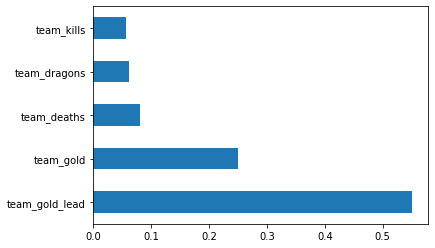

In [21]:
X = mh_df.drop(['result', 'team_barons', 'team_towers', 'team_assists'], axis = 1)
y = mh_df['result']
model = RandomForestClassifier( max_depth=10, max_features='log2', min_samples_split= 4, n_estimators=150)
model.fit(X , y)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
display(feat_importances.sort_values(ascending=False))
plt.show()

In [22]:
#Drop low information columns to prevent overfitting to the training data
x_data = mh_df.drop(['result', 'team_barons', 'team_towers', 'team_assists'], axis = 1)
y_data = mh_df['result']


In [23]:
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data , test_size=0.25, random_state=0)


In [24]:
ss_train = StandardScaler()
X_train = ss_train.fit_transform(X_train)

ss_test = StandardScaler()
X_test = ss_test.fit_transform(X_test)


In [25]:
models = {}
models['Logistic Regression'] = LogisticRegression()
models['Support Vector Machines'] = LinearSVC()
models['Decision Trees'] = DecisionTreeClassifier()
models['Random Forest'] = RandomForestClassifier()
models['Naive Bayes'] = GaussianNB()
models['K-Nearest Neighbor'] = KNeighborsClassifier()
models['Gradient Boost'] = GradientBoostingClassifier()



In [26]:
param_grid = {
            'Logistic Regression': {
                'penalty': [None, 'l1', 'l2', 'elasticnet'],
                'C': [100.0, 10.0, 1.0, 0.1, .01],
                'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cg', 'sag', 'saga'],
                },
            'Support Vector Machines': {
                'penalty': ['l1', 'l2'],
                'C': [100.0, 10.0, 1.0, 0.1, .01],
                },
            'Decision Trees': {
                },
            'Random Forest': {
                'n_estimators': [10, 50, 100, 150, 200],
                'max_depth': [None, 5, 7, 10, 20],
                'min_samples_split': [2, 4, 6, 8, 10],
                'max_features': ['sqrt', 'log2'],
                },
            'Naive Bayes': {
                },
            'K-Nearest Neighbor': {
                },
            'Gradient Boost': {
                'learning_rate': [0.01],
                'n_estimators': [60, 75, 90],
                'subsample':  [0.7, 0.75, 0.8],
                'max_depth': [6, 7, 8],
                },
}

In [27]:
accuracy, precision, recall, f1score = {}, {}, {}, {}


In [28]:
for key in models.keys():
    
    # Fit the classifier
    grid_search = GridSearchCV(estimator = models[key], param_grid= param_grid[key], cv = 5, n_jobs= -1)
    grid_search.fit(X_train, y_train)
    print(grid_search.best_params_)
    models[key] = grid_search.best_estimator_

    # Make predictions
    predictions = models[key].predict(X_test)
    
    # Calculate metrics
    accuracy[key] = accuracy_score(y_true = y_test, y_pred = predictions)
    precision[key] = precision_score(y_true = y_test, y_pred = predictions, pos_label = 'win')
    recall[key] = recall_score(y_true = y_test, y_pred = predictions, pos_label = 'win')
    f1score[key] = (2 * precision[key] * recall[key]) / (precision[key] + recall[key])


c:\Users\Ilemn\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan 0.7417378         nan        nan        nan 0.74168501
 0.74171141 0.74171141 0.74171141 0.74171141 0.74171141 0.74171141
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan 0.74171141        nan        nan        nan 0.74168501
 0.74171141 0.74171141 0.74171141 0.74171141 0.74171141 0.74171141
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan 0.74163221        nan        nan        nan 0.74163222
 0.74168501 0.74165861 0.74165861 0.74165861 0.74165861 0.74165861
        nan        nan        nan        nan        nan        nan
        nan        nan  

{'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}


c:\Users\Ilemn\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.72927814        nan 0.74091947        nan 0.74142107
        nan 0.74144746        nan 0.74139466]
  warnings.warn(
c:\Users\Ilemn\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


{'C': 0.1, 'penalty': 'l2'}
{}
{'max_depth': 10, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 150}
{}
{}
{'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 90, 'subsample': 0.75}


In [29]:
model_perf = pd.DataFrame(index=models.keys(), columns=['Accuracy', 'Precision', 'Recall', 'F1score'])
model_perf['Accuracy'] = accuracy.values()
model_perf['Precision'] = precision.values()
model_perf['Recall'] = recall.values()
model_perf['F1score'] = f1score.values()

model_perf

,Accuracy,Precision,Recall,F1score
Logistic Regression,0.740101,0.749520,0.731959,0.740635
Support Vector Machines,0.740101,0.750160,0.730709,0.740307
Decision Trees,0.654260,0.663455,0.645423,0.654315
Random Forest,0.736063,0.748020,0.722899,0.735245
Naive Bayes,0.729015,0.758411,0.683068,0.718771
K-Nearest Neighbor,0.707475,0.714921,0.703530,0.709180
Gradient Boost,0.738201,0.750081,0.725242,0.737452


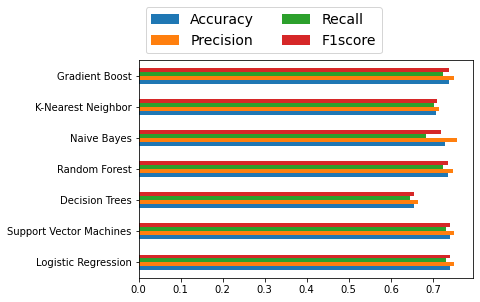

In [30]:
ax = model_perf.plot.barh()
ax.legend(
    ncol=2, 
    bbox_to_anchor=(0, 1), 
    loc='lower left', 
    prop={'size': 14}
)
plt.show()